In [34]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

from qutip import *
from qutip.control import *
from qutip.qip.operations import rx
from qutip.qip.operations import ry
from qutip.qip.operations import rz

from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from dataclasses import dataclass
from typing import List, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

from scipy.constants import physical_constants, h

from qutip import jmat, tensor, identity, Qobj

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_bloch_multivector

# Finding Pulse Sequence

### Setting beginning and ending states
### setting desired U value

In [35]:
qubit1state=basis(3, 0)
qubit2state=basis(3, 0)
startingstate=tensor(qubit1state,qubit1state) #initial state
endingstate= tensor(basis(3,2),basis(3,2))
startingstate.dims=[[9],[1]]
endingstate.dims=[[9],[1]]
print (startingstate)
print (endingstate)

U=endingstate * startingstate.dag()
U.dims=[[9],[9]]
U

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]

## Defining 3x3 pauli spin matrices 
## Definiting number of iterations
## Defining H_ops

In [36]:

R = 100 #GRAPE itterations

T = 1
times = np.linspace(0, T, 100)


#wirting our terms so I can actually read the hamiltonian
#Nuc terms are second qubit
#Elec qubit is first qubit
nuclear_spin = 1
electron_spin = 1

sigmaxE = jmat(electron_spin,'x')
sigmayE = jmat(electron_spin,'y')
sigmazE = jmat(electron_spin,'z')
sigmaxN = jmat(nuclear_spin,'x')
sigmayN = jmat(nuclear_spin,'y')
sigmazN = jmat(nuclear_spin,'z')
sigmazEsquared = sigmazE*sigmazE
sigmazNsquared = sigmazN*sigmazN
identity3 = identity(3) #3x3 identity matrix



#Creating operators that can be tuned in the Hamiltonian via the control fields, list is below called H_ops

H_opsEx=tensor(sigmaxE, identity3)
H_opsEy=tensor(sigmayE, identity3)
H_opsEz=tensor(sigmazE, identity3)

H_opsNx=tensor(identity3, sigmaxN)
H_opsNy=tensor(identity3, sigmayN)
H_opsNz=tensor(identity3, sigmazN)

H_opsENx = tensor(sigmaxE, sigmaxN)
H_opsENy = tensor(sigmayE, sigmayN)           
H_opsENz = tensor(sigmazE, sigmazN)


#changing dims bc qutip is silly

H_opsEx.dims=[[9],[9]]
H_opsEy.dims=[[9],[9]]
H_opsEz.dims=[[9],[9]]

H_opsNx.dims=[[9],[9]]
H_opsNy.dims=[[9],[9]]
H_opsNz.dims=[[9],[9]]

H_opsENx.dims=[[9],[9]]
H_opsENy.dims=[[9],[9]]
H_opsENz.dims=[[9],[9]] 


#making H_ops list           
H_ops = [H_opsEx, H_opsEy, H_opsEz, H_opsNx, H_opsNy, H_opsNz, H_opsENx, H_opsENy, H_opsENz]            
               
               
#making labels for pulse sequence graphs
H_labels = [r'$uE_{x}$',
            r'$uE_{y}$',
            r'$uE_{z}$',
            r'$uN_{x}$',
            r'$uN_{y}$',
            r'$uN_{z}$',
            r'$uEN_{x}$',
            r'$uEN_{y}$',
            r'$uEN_{z}$']


# Defining hamiltonian and constants 

In [37]:
#defining hamiltonian for NV center

#constants

f_fine_structure = 2.87e9
f_nuclear_quadrupole = -5.01e6
f_axial_magnetic_hyperfine = -2.14E6
f_transverse_magnetic_hyperfine = -2.7E6
g_factor_electron = 2.0028
gyromagnetic_constant_nuclear = 1.93297E7 / (2 * np.pi)
uB = physical_constants['Bohr magneton'][0]
uN = physical_constants['nuclear magneton'][0]    
bvector=[0,0,1]



@dataclass
class NVGroundParameters14N:
    nuclear_spin: int = 1
    electron_spin: int = 1
    f_fine_structure: float = 2.87E9
    f_nuclear_quadrupole: float = -5.01E6
    f_axial_magnetic_hyperfine: float = -2.14E6
    f_transverse_magnetic_hyperfine: float = -2.7E6
    g_factor_electron: float = 2.0028
    gyromagnetic_constant_nuclear: float = 1.93297E7 / (2 * np.pi) # Hz / Tesla

        
bvector=[0,0,1]
        
def nnplus1(n):
    return n * (n + 1)


def twonplus1(n):
    return 2 * n + 1


def get_nv_ground_hamiltonian(p:NVGroundParameters14N) -> Qobj:
    """
    Gets ground state hamiltonian in frequency units (h=1) with representation ordering S, I.
    From Doherty et a., Physics Reports 528 (2013).
    :param p: Ground state NV center parameters
    :return: Hamiltonian for interaction between electronic and nuclear spin
    """
    hh = p.f_fine_structure * tensor(jmat(p.electron_spin, 'z') ** 2 - (nnplus1(p.electron_spin) / 3) *
                                                                        identity(twonplus1(p.electron_spin)),
                                     identity(twonplus1(p.nuclear_spin))) + \
         p.f_axial_magnetic_hyperfine * tensor(jmat(p.electron_spin, 'z'), jmat(p.nuclear_spin, 'z')) + \
         p.f_transverse_magnetic_hyperfine * (tensor(jmat(p.electron_spin, 'x'), jmat(p.nuclear_spin, 'x')) +
                                              tensor(jmat(p.electron_spin, 'y'), jmat(p.nuclear_spin, 'y'))) + \
         p.f_nuclear_quadrupole * tensor(identity(twonplus1(p.electron_spin)), (jmat(p.nuclear_spin, 'z') ** 2 -
                                                                                identity(twonplus1(p.nuclear_spin)) *
                                                                                (nnplus1(p.nuclear_spin) / 3)))
    return hh


def get_nv_zeeman_hamiltonian(p:NVGroundParameters14N, bvector):
    """
    Zeeman Hamiltonian for both electronic and nuclear spin.
    :param p: Ground state NV center parameters
    :param bvector: Static magnetic field vector
    :return: The Zeeman Hamiltonian for a static magnetic field
    """
    h_zeeman = uB / h * p.g_factor_electron * tensor(jmat(p.electron_spin, 'x') * bvector[0] +
                                            jmat(p.electron_spin, 'y') * bvector[1] +
                                            jmat(p.electron_spin, 'z') * bvector[2], identity(twonplus1(p.nuclear_spin))) + \
          p.gyromagnetic_constant_nuclear * (tensor(identity(twonplus1(p.electron_spin)),
                                                    jmat(p.nuclear_spin, 'x') * bvector[0] +
                                                    jmat(p.nuclear_spin, 'y') * bvector[1] +
                                                    jmat(p.nuclear_spin, 'z') * bvector[2]))
    return h_zeeman



H1=get_nv_ground_hamiltonian(NVGroundParameters14N)
H2=get_nv_zeeman_hamiltonian(NVGroundParameters14N, bvector)
H0=H1+H2
H0.dims=[[9],[9]]
H0

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 2.89876124e+10  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.89916860e+10  0.00000000e+00 -2.70000000e+06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.89857396e+10  0.00000000e+00
  -2.70000000e+06  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -2.70000000e+06  0.00000000e+00 -1.91192692e+09
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.70000000e+06  0.00000000e+00
  -1.90999333e+09  0.00000000e+00 -2.70000000e+06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.91807975e+09  0.00000000e+00 -2.70000000e+06
   0.00000000e+00]
 [ 0

# Plot pulses

In [38]:
##creating initial control pulse values as starting guess for GRAPE

#u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])

#u0 = [np.convolve(np.ones(10) / 10, u0[idx, :], mode='same') for idx in range(len(H_ops))]


In [39]:
#doing GRAPE! #, u_start=u0

result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2 * pi / T, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time:   6.58s. Est. time left: 00:00:00:59
20.0%. Run time:  13.20s. Est. time left: 00:00:00:52
30.0%. Run time:  19.83s. Est. time left: 00:00:00:46
40.0%. Run time:  26.40s. Est. time left: 00:00:00:39
50.0%. Run time:  33.15s. Est. time left: 00:00:00:33
60.0%. Run time:  39.64s. Est. time left: 00:00:00:26
70.0%. Run time:  46.21s. Est. time left: 00:00:00:19
80.0%. Run time:  52.62s. Est. time left: 00:00:00:13
90.0%. Run time:  59.03s. Est. time left: 00:00:00:06
Total run time:  64.81s


/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  axes[j, 0].set_ylim(-y_max, y_max)
/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  axes[j, 0].set_ylim(-y_max, y_max)
/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  axes[j, 0].set_ylim(-y_max, y_max)
/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  axes[j, 0].set_ylim(-y_max, y_max)
/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: Us

/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  axes[j, 0].set_ylim(-y_max, y_max)
/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  axes[j, 0].set_ylim(-y_max, y_max)
/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  axes[j, 0].set_ylim(-y_max, y_max)
/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  axes[j, 0].set_ylim(-y_max, y_max)
/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: Us

/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  axes[j, 0].set_ylim(-y_max, y_max)
/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  axes[j, 0].set_ylim(-y_max, y_max)
/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  axes[j, 0].set_ylim(-y_max, y_max)
/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  axes[j, 0].set_ylim(-y_max, y_max)
/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: Us

/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  axes[j, 0].set_ylim(-y_max, y_max)
/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  axes[j, 0].set_ylim(-y_max, y_max)
/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  axes[j, 0].set_ylim(-y_max, y_max)
/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  axes[j, 0].set_ylim(-y_max, y_max)
/opt/anaconda3/lib/python3.9/site-packages/qutip/control/grape.py:93: Us

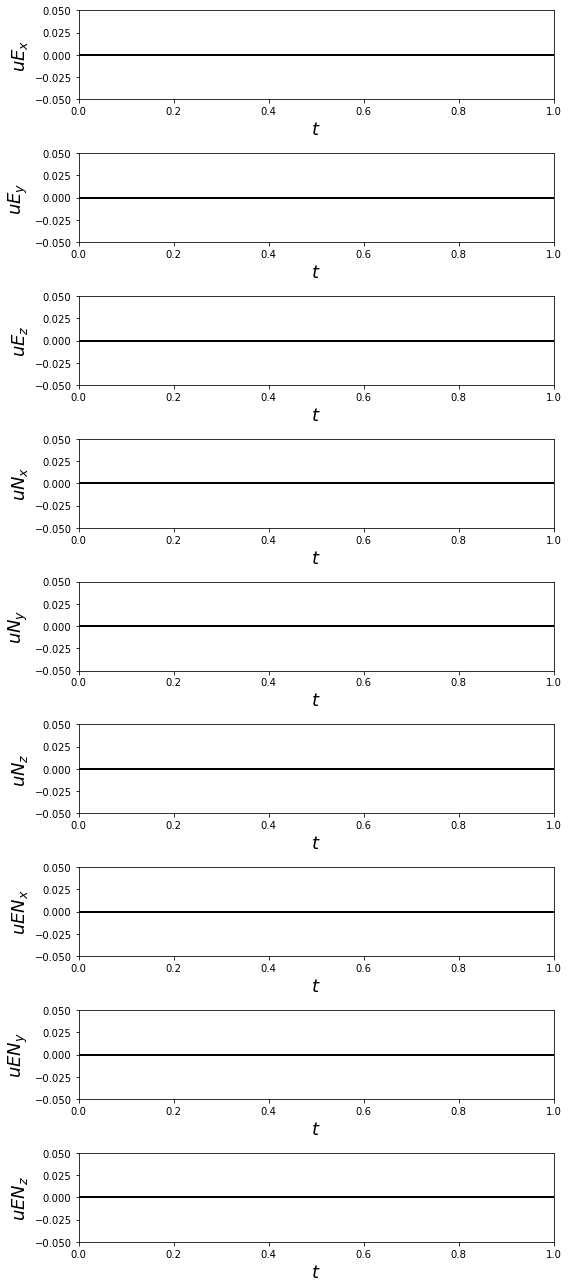

In [45]:
plot_grape_control_fields(times, result.u[:, :, :] / (2 * pi), H_labels, uniform_axes=True);
plt.show()

# Calcuate fidelity

In [41]:
idealfinalstate=U*startingstate
print (idealfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [42]:
result.U_f.tidyup(1e-2)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[-0.91439907+0.40481471j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.91112273+0.41213619j  0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.09767345-0.99521668j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.92882736+0.37051065j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.  

In [43]:
realfinalstate=result.U_f*startingstate
print (realfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[-0.91439907+0.40481471j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]]


In [44]:
idealdensitymatrix=(idealfinalstate * idealfinalstate.dag())#ideal density matrix
densitymatrix=(realfinalstate * realfinalstate.dag())# real density matrix
print (idealdensitymatrix)
print (densitymatrix)
fidelity(idealdensitymatrix,densitymatrix)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[1.0000006 0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [0.        0.       

0.0

# Plotting City Scape


In [55]:
#plotting cityscape for real density matrix
dm=np.array(densitymatrix)
print (dm)
plot_state_city(dm, title='State Tomography for Real State')

[[ 0.15081582+0.j          0.14160228+0.02722125j -0.17380785-0.06234141j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.18205341-0.05762696j  0.        +0.j          0.18229072-0.05905361j]
 [ 0.14160228-0.02722125j  0.13786487+0.j         -0.17444192-0.02716173j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.16053025-0.08696588j  0.        +0.j          0.16049556-0.0883482j ]
 [-0.17380785+0.06234141j -0.17444192+0.02716173j  0.22607457+0.j
   0.        +0.j          0.        +0.j          0.        +0.j
  -0.1859869 +0.14166607j  0.        +0.j         -0.18567067+0.1434083j ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j       

VisualizationError: 'Input is not a multi-qubit quantum state.'

In [56]:
#plotting cityscape for ideal density matrix
idm=np.array(idealdensitymatrix)
print (idm)
plot_state_city(idm, title='State Tomography for Ideal State')

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


VisualizationError: 'Input is not a multi-qubit quantum state.'